### Notebook Purpose

Perform quant and qual evaluation for fastmri results in ismrm paper

Note: code used to create ismrm output, i.e. model6 below, are in the directory `~/old_ConvDecoder_pt1.5_20201208/` OR if tmux env still up, go into `~/old_code_mod_for_pt1.7/` and enter `tmux attach -t old_dvv`

# TODO: merge codebases w/o performance discrepancy
- potential issues across pt versions
    - fft/ifft work differently
    - low-level detail w torch, torchvision, etc
        - recall: csdip worked much worse on a newer version of pytorch
        - but also it works well on qdess, so must be dataset-specific
- see results below for ssim/psnr values over n=5 samples
- potential solutions
    - retrofit current method (pt==1.7) and to work with old fft/ifft while using pt==1.7
        - first test to see whether there's a difference b/w running...
            - new fft/ifft in pt==1.7
            - old fft/ifft in pt==1.7
            - old fft/ifft in pt==1.5
        - if no difference, then maybe don't retrofit
    - start with old method (in `old` branch/venv running pt==1.5)
        - run qdess w this and see if qdess results are same as pt==1.7
        - if so, apply new data processing / functions built when originally converted pt==1.5-->1.7, but keep the fft/ifft functions as old because need to use pt==1.5

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5
from utils.evaluate import calc_metrics, norm_imgs
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

In [15]:
def load_gt(file_id):
    _, ksp_orig = load_h5(file_id)
    ksp_orig = torch.from_numpy(ksp_orig)
    return crop_center(root_sum_squares(ifft_2d(ksp_orig)), DIM, DIM)

def load_fastmri_baseline(file_id, path_bl):
    ''' given file_id e.g. 1000818, load from pre-defined directory '''
    
    arr = torch.from_numpy(np.load('{}file{}.npy'.format(path_bl, file_id)))
    
    # get central slice
    idx_kx = arr.shape[0] // 2
    arr = arr[idx_kx, :, :, :, :]
    
    # combine real/complex values
    arr_new = torch.empty((arr.shape[0], arr.shape[1]), dtype=torch.complex64)
    arr_new.real = arr[:, :, 0, 0]
    arr_new.imag = arr[:, :, 0, 1]
    
    return np.array(torch.absolute(arr_new))  

def plot_list(arr_list, clim=(0, .1)):
    
    NUM_COLS = len(arr_list)
    title_list = ['ground-truth', 'dd+', 'u-net']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

### define test set list

In [3]:
# pp = '/bmrNAS/people/dvv/multicoil_val/'
# ff = [f for f in listdir(pp) if isfile(join(pp, f))]
# ff = [f.split('.h5')[0].split('file')[1] for f in ff]
# ff.sort()
# f1, f2 = ff[:100], ff[100:]
# # f1.reverse()
# # f1

### compare old dd+ (pytorch==1.5) vs new dd+ (pytorch==1.7)

from the baseline directory `/bmrNAS/people/dvv/out_fastmri/`...
- (1) `old_pytorch1.5/orig_alpha_search/` (n=11): using dd+ pt==1.5 before code re-work 
- (2) `old_pytorch1.5/sf0.1/` (n=5): using dd+ pt==1.5 after code re-work, then converted back
    - not sure if this is actually in pt==1.5 or if i just took pt==1.7 and used the deprecated fft/ifft functions in a hacky way. either way, i might have this stashed in a branch somewhere?
- (3) `new_pytorch1.7/sf0.1/` (n=5): using dd+ pt==1.7 sf0.1 w `fit.py`
- (4) `expmt_fm_loss/trials_best/` (n=11): using dd+ pt==1.7 sf=0.1 w `fit_feat_map_loss.py` instead of `fit.py`
    - i.e. looking at trial_id = `0000_10k`

##### results
- 1 > 4
- 2 > 1, but we only have five samples for 2
- 2, 3 are comparable
- ssim, psnr
    - (1)
        - n=5: 0.7884340675904544 31.730754973365197
        - n=11: 0.7569765714478369 30.87466793360071
    - (2) 0.796467652242989 32.034361010080524
    - (3) 0.793504546953909 31.93507930075753
    - (4)
        - n=5: 0.7647340218936469 30.56831878262691
        - n=11: 0.7399233683613828 29.98914482917978

# TODO
- decide whether to run over 8x -- ask arjun
- currently running over test samples in `ismrm/model6/`
    - evaluate output over entire set for final quant results
- run over some samples from annotated samples in csv per akshay
    - determine qual samples for display
- run fm_reg in old env

### model list
- `ismrm/model5/`: run current processing (pt==1.7, recent code) w scale_factor=0.1 using `fit.py`. if this yields decent results, will indicate that there is some discrepancy when alpha_fm=0 calling `fit_feat_map.py`
    - got ssim .7694 across n=5 --> too low
- `ismrm/model6/`: run old processing (pt==1.5, code pulled from git branch old_code_mod_for_pt1.7 + converted back to old fft/ifft)
    - got ssim .7885 across n=5 --> will work for paper
    - how to re-create this? use python venv `old_pt_heck` and run `python_run_expmt_test_old_v_new.py`
    - TODO: merge this with current processing...

In [28]:
path_base = '/bmrNAS/people/dvv/out_fastmri/'
path_1 = path_base + 'old_pytorch1.5/orig_alpha_search/'
path_2 = path_base + 'old_pytorch1.5/sf0.1/'
path_3 = path_base + 'new_pytorch1.7/sf0.1/'
path_4 = path_base + 'expmt_fm_loss/trials_best/'
path_5 = path_base + 'ismrm/model5/'
path_6 = path_base + 'ismrm/model6/'

# path to baselines
path_bl_1 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_4x_dev/20_percent/test_results/fastMRI_knee_multicoil_v0.0.1_test/'
path_bl_2 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_4x_dev/full/test_results/fastMRI_knee_multicoil_v0.0.1_test/'
path_bl = path_bl_2

# n = 5 or n = 11 prototyping test set
file_id_list = ['1000273', '1000325', '1000464', \
                '1000537', '1000818', '1001140', '1001219', \
                '1001338', '1001598', '1001533', '1001798']
# file_id_list = ['1000273', '1000325', '1000464', '1000537', '1000818']

# full test set
# file_id_list = list(set([f.split('_')[0] for f in listdir(path_6) if isfile(join(path_6, f))]))
file_id_list.sort()

In [30]:
DIM = 320
NUM_SAMPS = len(file_id_list)
NUM_VARS = 3 # ground-truth, our output, original baseline
NUM_METRICS = 4 # vif, msssim, ssim, psnr

im_list = np.empty((NUM_SAMPS, NUM_VARS, DIM, DIM))
metric_dc_list = np.empty((NUM_SAMPS, NUM_METRICS))
metric_bl_list = np.empty((NUM_SAMPS, NUM_METRICS))

for idx, file_id in enumerate(file_id_list):
    
    img_gt = np.array(load_gt(file_id))
    img_bl = load_fastmri_baseline(file_id, path_bl)
    
    img_dc = np.load('{}{}_dc.npy'.format(path_6, file_id)).astype('float32')
#     img_dc = np.load('{}{}_iter10000_alpha0.npy'.format(path_1, file_id))
#     img_dc = np.load('{}0000_10k_{}_dc.npy'.format(path_4, file_id))   

    img_gt, img_dc = norm_imgs(img_gt, img_dc)
    img_gt, img_bl = norm_imgs(img_gt, img_bl)
        
    metric_dc_list[idx] = calc_metrics(img_gt, img_dc, imgs_already_normed=True)
    metric_bl_list[idx] = calc_metrics(img_gt, img_bl, imgs_already_normed=True)
    
    im_list[idx] = [img_gt, img_dc, img_bl]

#     img_diff = np.abs(img_dc - img_gt)

print('dd+')
print(np.mean(metric_dc_list, axis=0))

print('\nu-net')
print(np.mean(metric_bl_list, axis=0))


dd+
[ 0.65099646  0.94691538  0.76467066 31.92233131]

u-net
[ 0.66758529  0.93868854  0.76999943 31.11004939]


##### prelim results -- metrics computed over 73/101 samples in val set

dd+
[ 0.68402424  0.94416455  0.76882118 31.54299076]

u-net, expmt 1
[ 0.70964022  0.92548806  0.76399353 30.65031426]

u-net, expmt 2
[ 0.69305595  0.92876906  0.76443703 30.69887474]

1000000


SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


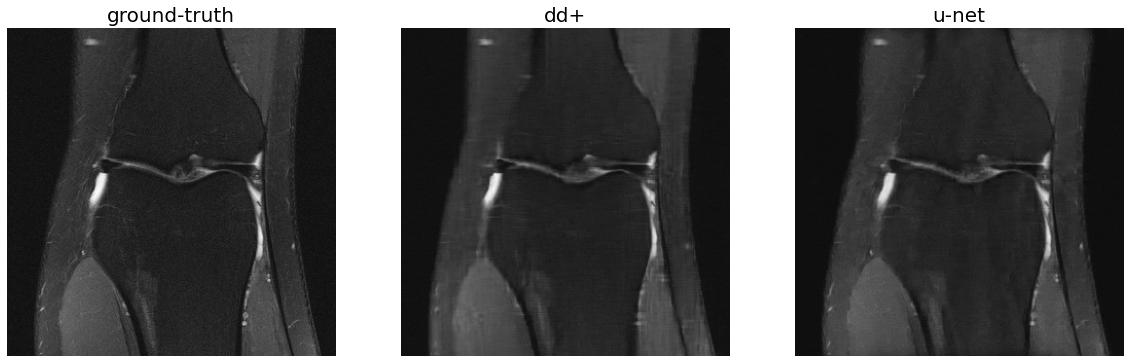

In [20]:
for idx in np.arange(30):
    print(file_id_list[idx])
    plot_list(im_list[idx])
    sys.exit()

### load arjun pre-calculated results

In [10]:
# csv_bl_2 trained over more samples. use for slightly better results
csv_bl_1 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_4x_dev/20_percent/test_results/metrics.csv'
csv_bl_2 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_4x_dev/full/test_results/metrics.csv'

df = pd.read_csv(csv_bl_2)

file_id_list_str = ['file' + str(f) for f in file_id_list]
df_ = df.loc[df['scan_name'].isin(file_id_list_str)]
df_ = df_[df_['rescaled']==True]


ssim_str = 'ssim_old' # use 'ssim (Wang)' for slightly better results
print(df_[ssim_str].mean())

df_.head()

0.7690529010777387


,Unnamed: 0,scan_name,l1,l2,psnr,ssim_old,ssim (Wang),nrmse,l1_scan,l2_scan,...,ssim (Wang)_scan,nrmse_scan,Method,Acceleration,dataset,Noise Level,weights,rescaled,Criterion Name,Criterion Val
0,0,file1000000,0.000003,0.000004,30.505470,0.769331,0.775260,0.160914,0.000003,0.000004,...,0.894116,0.136007,GeneralizedUnrolledCNN,4,fastMRI_knee_multicoil_v0.0.1_test,0,model_0066335.pth,True,val_l1,0.000006
1,1,file1000007,0.000005,0.000006,23.688932,0.576397,0.580571,0.308359,0.000005,0.000006,...,0.794731,0.242253,GeneralizedUnrolledCNN,4,fastMRI_knee_multicoil_v0.0.1_test,0,model_0066335.pth,True,val_l1,0.000006
2,2,file1000017,0.000003,0.000004,28.105960,0.690678,0.695719,0.238385,0.000003,0.000004,...,0.858850,0.202304,GeneralizedUnrolledCNN,4,fastMRI_knee_multicoil_v0.0.1_test,0,model_0066335.pth,True,val_l1,0.000006
3,3,file1000026,0.000003,0.000004,27.568079,0.673781,0.682419,0.211546,0.000003,0.000004,...,0.848266,0.198570,GeneralizedUnrolledCNN,4,fastMRI_knee_multicoil_v0.0.1_test,0,model_0066335.pth,True,val_l1,0.000006
4,4,file1000031,0.000006,0.000007,30.116110,0.794174,0.797859,0.150646,0.000006,0.000007,...,0.912237,0.125120,GeneralizedUnrolledCNN,4,fastMRI_knee_multicoil_v0.0.1_test,0,model_0066335.pth,True,val_l1,0.000006
